In [1]:
%load_ext autoreload
%autoreload 2

In [52]:
from pathlib import Path
import sys
project_path = Path.cwd().parent
sys.path.append(project_path.as_posix())

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scripts.plot_utils import compute_plot_corr_matrix

from pipeline.p0_data_loader import DataLoader
from pipeline.p1_model_trainer import XGBoostTrainer
from loguru import logger

### 0 - Load Data

In [3]:
data_path = Path.home() / 'data/craig_pfc_2023/step_2_cleaned'
assert data_path.exists()
[i for i in data_path.glob('*.pqt')]

[PosixPath('/Users/erdemkarakoylu/data/craig_pfc_2023/step_2_cleaned/df_phy.pqt'),
 PosixPath('/Users/erdemkarakoylu/data/craig_pfc_2023/step_2_cleaned/df_rrs.pqt'),
 PosixPath('/Users/erdemkarakoylu/data/craig_pfc_2023/step_2_cleaned/df_env.pqt'),
 PosixPath('/Users/erdemkarakoylu/data/craig_pfc_2023/step_2_cleaned/df_all.pqt')]

In [4]:
loader = DataLoader(
    data_path=data_path, rrs_file = 'df_rrs.pqt', 
    phy_file='df_phy.pqt', env_file='df_env.pqt')

2025-03-10 15:43:24.215 | DEBUG    | pipeline.p0_data_loader:__init__:18 - Data directory set to /Users/erdemkarakoylu/data/craig_pfc_2023/step_2_cleaned
2025-03-10 15:43:24.215 | DEBUG    | pipeline.p0_data_loader:__init__:19 - Rrs file used: df_rrs.pqt
2025-03-10 15:43:24.216 | DEBUG    | pipeline.p0_data_loader:__init__:20 - Phytoplankton file use df_phy.pqt


2025-03-10 15:43:24.216 | DEBUG    | pipeline.p0_data_loader:__init__:22 - Env file used: df_env.pqt


In [ ]:
dX, dX_env, dY =  loader.load_data()

#### Quick EDA

In [6]:
dX.shape, dX_env.shape, dY.shape

((1261607, 501), (1261607, 5), (1261607, 7))

In [7]:
dX = dX.iloc[:, ::10]

In [73]:
dX.shape, dX_env.shape, dY.shape

((1261607, 51), (1261607, 5), (1261607, 7))

In [74]:
dX.to_parquet(data_path/'df_rrs_every_every10_51total_bands.pqt')

##### Retaining only that environmental data accessible via satellite.

In [14]:
dX_env_sub = dX_env[['lat', 'temp']]

In [9]:
dX_env.head()

,lat,temp,nitrate,iron,silica
9,-84.0,0.857763,12.907951,0.182768,28.479807
10,-84.0,0.846447,15.581422,0.282881,28.604376
11,-84.0,0.827969,16.857571,0.318571,29.003593
12,-84.0,0.810619,17.345680,0.326929,29.388382
13,-84.0,0.801506,17.232298,0.319819,29.552345


In [10]:
dX_env.describe()

,lat,temp,nitrate,iron,silica
count,1.261607e+06,1.261607e+06,1.261607e+06,1.261607e+06,1.261607e+06
mean,-6.470441e+00,1.616145e+01,5.515115e+00,3.142371e-01,7.914522e+00
std,4.505472e+01,1.032092e+01,7.313258e+00,2.591170e-01,1.001315e+01
min,-8.400000e+01,-1.017889e+00,8.000412e-04,5.048735e-03,1.938913e-03
25%,-4.531674e+01,5.567214e+00,4.595803e-02,1.703310e-01,1.419863e+00
50%,-6.633476e+00,1.889113e+01,4.257810e-01,2.184942e-01,3.390273e+00
75%,3.271674e+01,2.593674e+01,1.100956e+01,3.516443e-01,9.888976e+00
max,7.140000e+01,3.051188e+01,4.287701e+01,1.053397e+01,9.514703e+01


In [20]:
dX_env_sub.head()

,lat,temp
9,-84.0,0.857763
10,-84.0,0.846447
11,-84.0,0.827969
12,-84.0,0.810619
13,-84.0,0.801506


In [15]:
dX_all = pd.concat((dX, dX_env_sub), axis=1)

<Axes: >

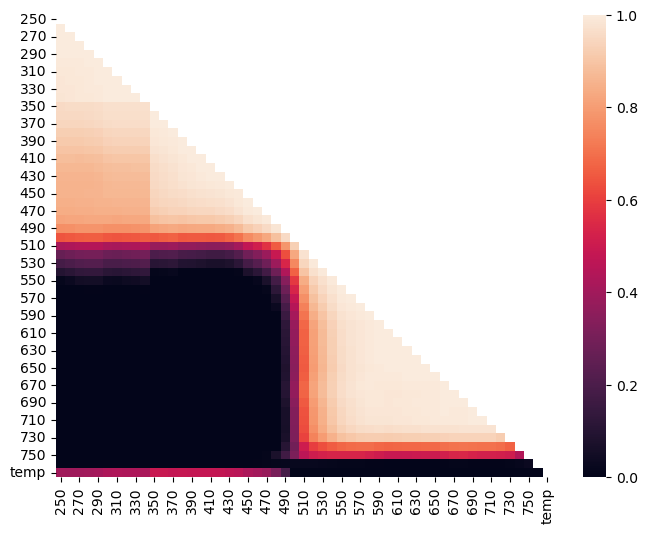

In [17]:
compute_plot_corr_matrix(dX_all.corr())

Half the Rrs

In [23]:
dX_sub = pd.concat((dX.loc[:, ::2], dX_env_sub, dY), axis=1)

<Axes: >

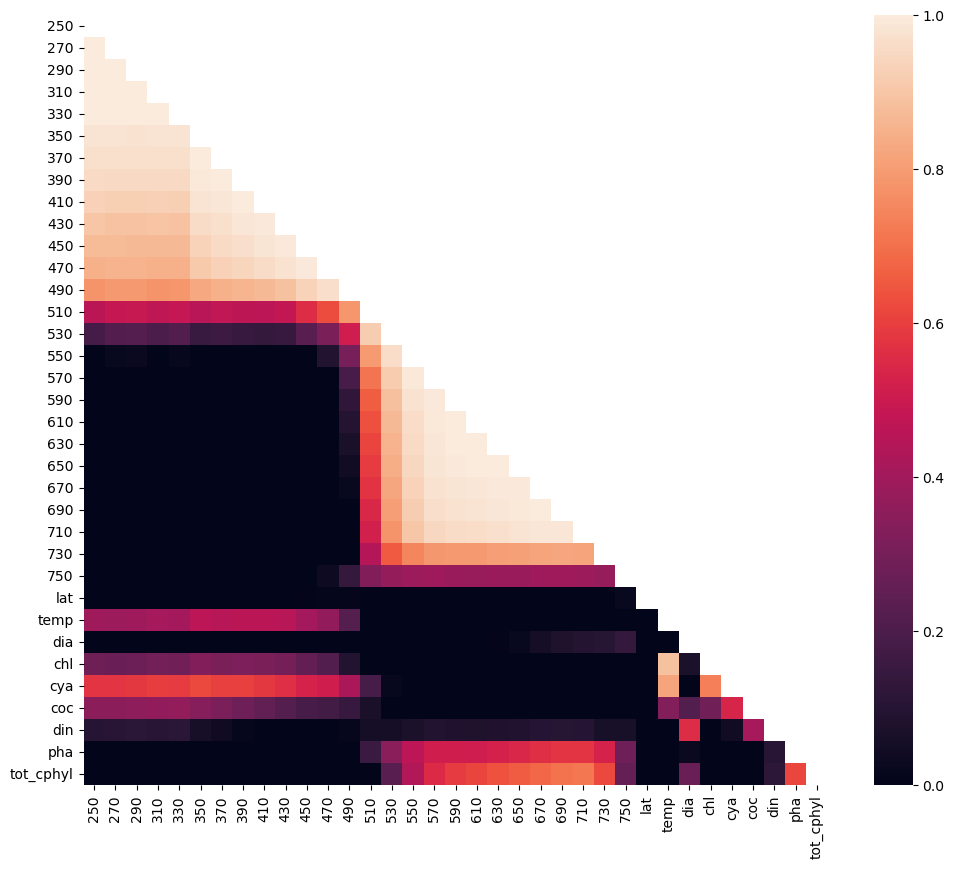

In [24]:
compute_plot_corr_matrix(
    dX_sub.corr(method='spearman'), figsize=(12, 10))

#### Split the data

In [27]:
idx_train, idx_test= train_test_split(dX.index)

In [28]:
dX_train, dX_test = dX_all.loc[idx_train], dX_all.loc[idx_test]
dY_train, dY_test = dY.loc[idx_train], dY.loc[idx_test]

#### Standardize both input and output

In [ ]:
scl_X = StandardScaler()
scl_Y = StandardScaler()

In [32]:
dX_train.head()

,250,260,270,280,290,300,310,320,330,340,...,680,690,700,710,720,730,740,750,lat,temp
1632875,0.002217,0.002204,0.002215,0.002310,0.002462,0.002778,0.002964,0.003086,0.003229,0.003360,...,0.000136,0.000123,0.000099,0.000075,0.000049,0.000035,0.000024,0.000020,37.385408,0.821719
857042,0.002431,0.002422,0.002439,0.002564,0.002763,0.003197,0.003452,0.003607,0.003788,0.003945,...,0.000089,0.000080,0.000062,0.000051,0.000026,0.000022,0.000000,0.000000,-20.639485,28.372089
1272987,0.002177,0.002157,0.002161,0.002246,0.002384,0.002679,0.002846,0.002951,0.003076,0.003190,...,0.000096,0.000085,0.000067,0.000052,0.000034,0.000020,0.000011,0.000013,10.707296,0.876914
1155396,0.002950,0.002976,0.003037,0.003263,0.003618,0.004407,0.004918,0.005248,0.005633,0.005964,...,0.000107,0.000093,0.000077,0.000057,0.000039,0.000028,0.000021,0.000013,2.036910,27.166430
973901,0.002538,0.002532,0.002553,0.002687,0.002901,0.003365,0.003640,0.003810,0.004010,0.004189,...,0.000084,0.000073,0.000057,0.000042,0.000029,0.000006,0.000012,0.000013,-11.302146,3.396274


In [36]:
dX_train.columns=dX_train.columns.astype(str)
dX_test.columns=dX_test.columns.astype(str)

In [ ]:
dX_train_s = pd.DataFrame(scl_X.fit_transform(dX_train), columns=dX_train.columns)
dX_test_s = pd.DataFrame(scl_X.transform(dX_test), columns=dX_test.columns)
dY_train_s = pd.DataFrame(scl_Y.fit_transform(dY_train), columns=dY_train.columns)

In [42]:
dX_train_s.iloc[:, ::2].describe().T

,count,mean,std,min,25%,50%,75%,max
250,946205.0,-4.181381e-16,1.000001,-7.198345,-0.542728,0.210282,0.748247,3.790259
270,946205.0,4.680306e-16,1.000001,-6.621801,-0.562403,0.199143,0.755325,4.954657
290,946205.0,3.172569e-16,1.000001,-5.642432,-0.599061,0.173002,0.764672,5.288323
310,946205.0,-3.530767e-16,1.000001,-4.493283,-0.652093,0.124276,0.769522,4.792459
330,946205.0,1.234995e-16,1.000001,-4.131667,-0.672752,0.105390,0.768433,5.138506
350,946205.0,1.393594e-16,1.000001,-3.626080,-0.659660,0.073990,0.757620,5.367749
370,946205.0,-1.154419e-16,1.000001,-3.382652,-0.691022,0.033494,0.743007,5.329903
390,946205.0,-1.716704e-16,1.000001,-2.970480,-0.696649,-0.028839,0.703799,4.728693
410,946205.0,-1.441091e-16,1.000001,-2.794486,-0.686984,-0.062837,0.675676,4.634455
430,946205.0,-8.066968e-18,1.000001,-2.892397,-0.684058,-0.056656,0.687386,5.328862


In [44]:
dX_train_s.describe()

,250,260,270,280,290,300,310,320,330,340,...,680,690,700,710,720,730,740,750,lat,temp
count,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,...,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05
mean,-4.181381e-16,-4.925337e-16,4.680306e-16,-2.172618e-16,3.172569e-16,1.821329e-16,-3.530767e-16,1.687812e-16,1.234995e-16,-1.281253e-16,...,6.470095e-17,-6.408518e-17,-1.705196e-16,1.214908e-16,1.466285e-16,1.224369e-16,3.342432e-17,3.872971e-17,-1.013693e-16,-7.195052e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-7.198345e+00,-6.904092e+00,-6.621801e+00,-6.162049e+00,-5.642432e+00,-4.865593e+00,-4.493283e+00,-4.308219e+00,-4.131667e+00,-4.018916e+00,...,-1.581674e+00,-1.537330e+00,-1.543130e+00,-1.677049e+00,-1.965376e+00,-2.228630e+00,-1.747095e+00,-1.473940e+00,-1.720999e+00,-1.664139e+00
25%,-5.427278e-01,-5.525767e-01,-5.624025e-01,-5.788560e-01,-5.990605e-01,-6.331228e-01,-6.520925e-01,-6.625321e-01,-6.727515e-01,-6.793900e-01,...,-6.473163e-01,-6.369058e-01,-6.263816e-01,-6.221530e-01,-6.097437e-01,-6.589817e-01,-6.210704e-01,-4.881587e-01,-8.624424e-01,-1.026606e+00
50%,2.102823e-01,2.048154e-01,1.991429e-01,1.879325e-01,1.730020e-01,1.425527e-01,1.242761e-01,1.146095e-01,1.053902e-01,1.018873e-01,...,-3.017591e-01,-3.005404e-01,-2.968198e-01,-2.950685e-01,-2.509474e-01,-1.871798e-01,-3.445237e-01,6.468446e-02,-3.886195e-03,2.637243e-01
75%,7.482474e-01,7.518006e-01,7.553246e-01,7.600375e-01,7.646723e-01,7.688819e-01,7.695215e-01,7.696517e-01,7.684332e-01,7.661175e-01,...,3.144074e-01,3.020984e-01,2.919533e-01,2.891754e-01,3.000234e-01,3.449179e-01,6.763550e-01,4.781562e-01,8.694727e-01,9.473251e-01
max,3.790259e+00,4.377190e+00,4.954657e+00,5.225811e+00,5.288323e+00,4.757371e+00,4.792459e+00,4.989192e+00,5.138506e+00,5.347218e+00,...,2.985222e+01,2.899608e+01,2.845474e+01,2.865980e+01,2.863521e+01,2.835731e+01,2.522092e+01,2.450415e+01,1.728029e+00,1.391031e+00


In [45]:
dY_train_s.describe()

,dia,chl,cya,coc,din,pha,tot_cphyl
count,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05
mean,1.469138e-16,1.904383e-16,-2.103231e-16,-1.555121e-16,4.730919e-18,-9.096130e-17,5.771721e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-5.539838e-01,-4.647147e-01,-7.452448e-01,-4.560299e-01,-8.765204e-02,-2.848943e-01,-6.557339e-01
25%,-5.522839e-01,-4.647147e-01,-7.452448e-01,-4.555539e-01,-8.765204e-02,-2.848943e-01,-4.331862e-01
50%,-5.144513e-01,-4.627913e-01,-6.456523e-01,-4.044882e-01,-8.765204e-02,-2.848943e-01,-2.358186e-01
75%,1.094439e-01,-8.350487e-02,5.896739e-01,-6.922571e-02,-8.765201e-02,-2.831872e-01,1.277747e-01
max,1.373858e+01,2.237233e+01,1.666102e+01,2.177167e+01,1.104863e+02,2.785285e+01,2.852328e+01


#### Fitting a model

In [46]:
params = {
    "objective": "reg:squarederror", # Basic parameter
    "n_estimators": 50,             # Small number for faster testing
    "seed": 42,                      # Reproducibility
    }

In [47]:
trainer = XGBoostTrainer(params=params)
xgbmodel = trainer.train_model(dX_train_s, dY_train_s)

/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:406: DeprecationWarning: The following error was raised: 'super' object has no attribute '__sklearn_tags__'. It seems that there are no classes that implement `__sklearn_tags__` in the MRO and/or all classes in the MRO call `super().__sklearn_tags__()`. Make sure to inherit from `BaseEstimator` which implements `__sklearn_tags__` (or 

In [70]:
xgbmodel

/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:406: DeprecationWarning: The following error was raised: 'super' object has no attribute '__sklearn_tags__'. It seems that there are no classes that implement `__sklearn_tags__` in the MRO and/or all classes in the MRO call `super().__sklearn_tags__()`. Make sure to inherit from `BaseEstimator` which implements `__sklearn_tags__` (or 

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [48]:
Y_pred_s = xgbmodel.predict(dX_test_s)
Y_pred = scl_Y.inverse_transform(Y_pred_s)
dY_pred = pd.DataFrame(
    Y_pred, columns=dY_test.columns
    )

/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:406: DeprecationWarning: The following error was raised: 'super' object has no attribute '__sklearn_tags__'. It seems that there are no classes that implement `__sklearn_tags__` in the MRO and/or all classes in the MRO call `super().__sklearn_tags__()`. Make sure to inherit from `BaseEstimator` which implements `__sklearn_tags__` (or 

In [50]:
dY_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315402 entries, 0 to 315401
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   dia        315402 non-null  float32
 1   chl        315402 non-null  float32
 2   cya        315402 non-null  float32
 3   coc        315402 non-null  float32
 4   din        315402 non-null  float32
 5   pha        315402 non-null  float32
 6   tot_cphyl  315402 non-null  float32
dtypes: float32(7)
memory usage: 8.4 MB


In [49]:
dY_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315402 entries, 950842 to 1653958
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   dia        315402 non-null  float64
 1   chl        315402 non-null  float64
 2   cya        315402 non-null  float64
 3   coc        315402 non-null  float64
 4   din        315402 non-null  float64
 5   pha        315402 non-null  float64
 6   tot_cphyl  315402 non-null  float64
dtypes: float64(7)
memory usage: 19.3 MB


In [53]:
from scripts.plot_utils import plot_regression, plot_residuals
from scripts.evaluate import plot_shap, compute_shapley_values, get_main_features
import matplotlib.pyplot as pp

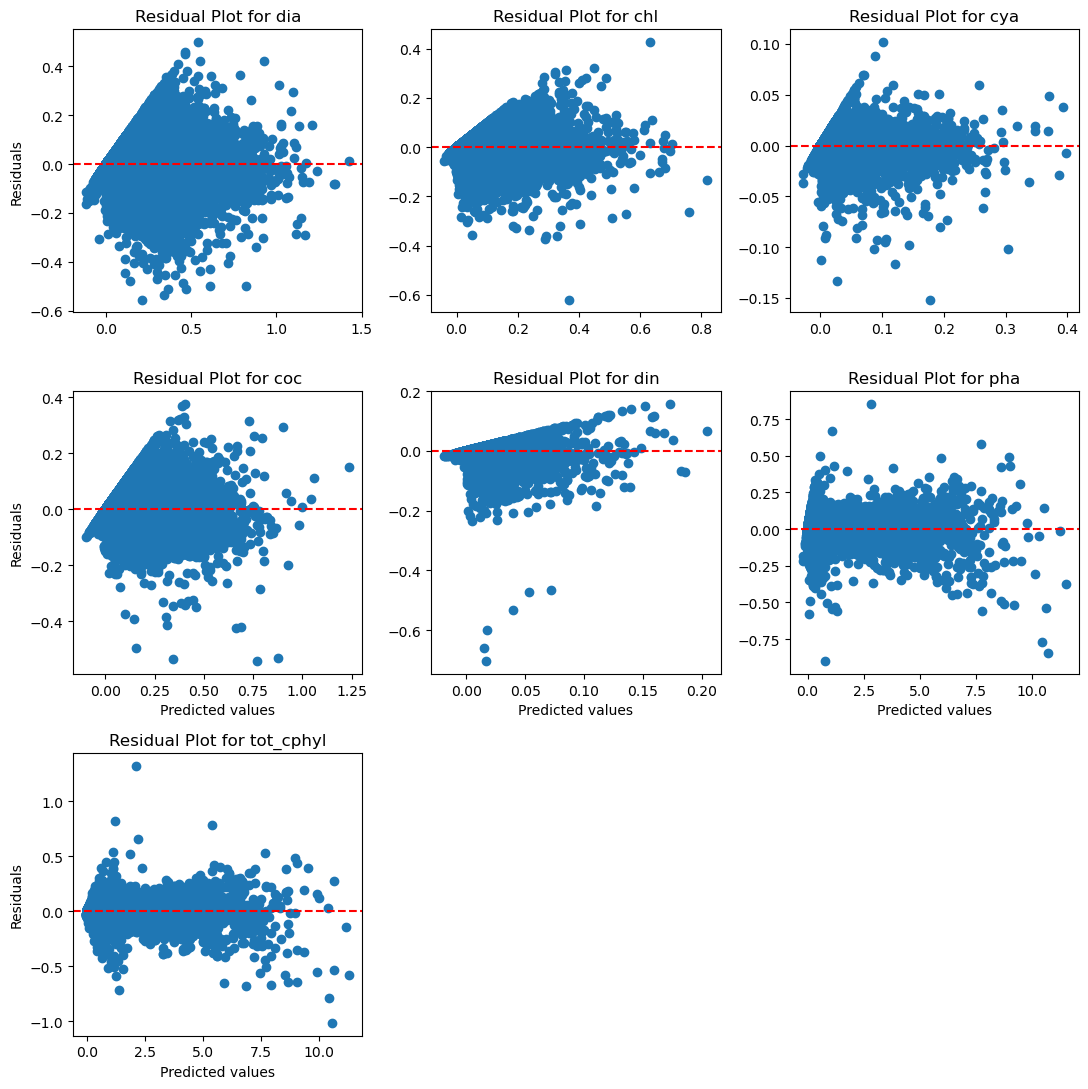

In [54]:
f, axs = pp.subplots(nrows=3, ncols=3, figsize=(11, 11))
for ax, col in zip(axs.ravel(), dY_test.columns):
    try:
        plot_residuals(dY_test[col].values, dY_pred[col].values, ax, col)
    except:
        logger.error(f"problem with {col}")
axs.ravel()[-2].set_visible(False)
axs.ravel()[-1].set_visible(False)
f.tight_layout()   

In [56]:
from scripts.evaluate import model_eval

In [57]:
eval_scores = model_eval(dY_test, dY_pred)

2025-03-10 16:45:57.402 | INFO     | scripts.evaluate:model_eval:23 - 
Metrics for dia:
2025-03-10 16:45:57.402 | INFO     | scripts.evaluate:model_eval:24 -   MSE: 0.0012
2025-03-10 16:45:57.402 | INFO     | scripts.evaluate:model_eval:25 -   RMSE: 0.0351
2025-03-10 16:45:57.403 | INFO     | scripts.evaluate:model_eval:26 -   MAE: 0.0180
2025-03-10 16:45:57.403 | INFO     | scripts.evaluate:model_eval:27 -   R-squared: 0.9221
2025-03-10 16:45:57.403 | INFO     | scripts.evaluate:model_eval:28 -   MAE/StDev_true 0.143
2025-03-10 16:45:57.410 | INFO     | scripts.evaluate:model_eval:23 - 
Metrics for chl:
2025-03-10 16:45:57.411 | INFO     | scripts.evaluate:model_eval:24 -   MSE: 0.0003
2025-03-10 16:45:57.411 | INFO     | scripts.evaluate:model_eval:25 -   RMSE: 0.0166
2025-03-10 16:45:57.411 | INFO     | scripts.evaluate:model_eval:26 -   MAE: 0.0078
2025-03-10 16:45:57.411 | INFO     | scripts.evaluate:model_eval:27 -   R-squared: 0.8855
2025-03-10 16:45:57.412 | INFO     | scripts.

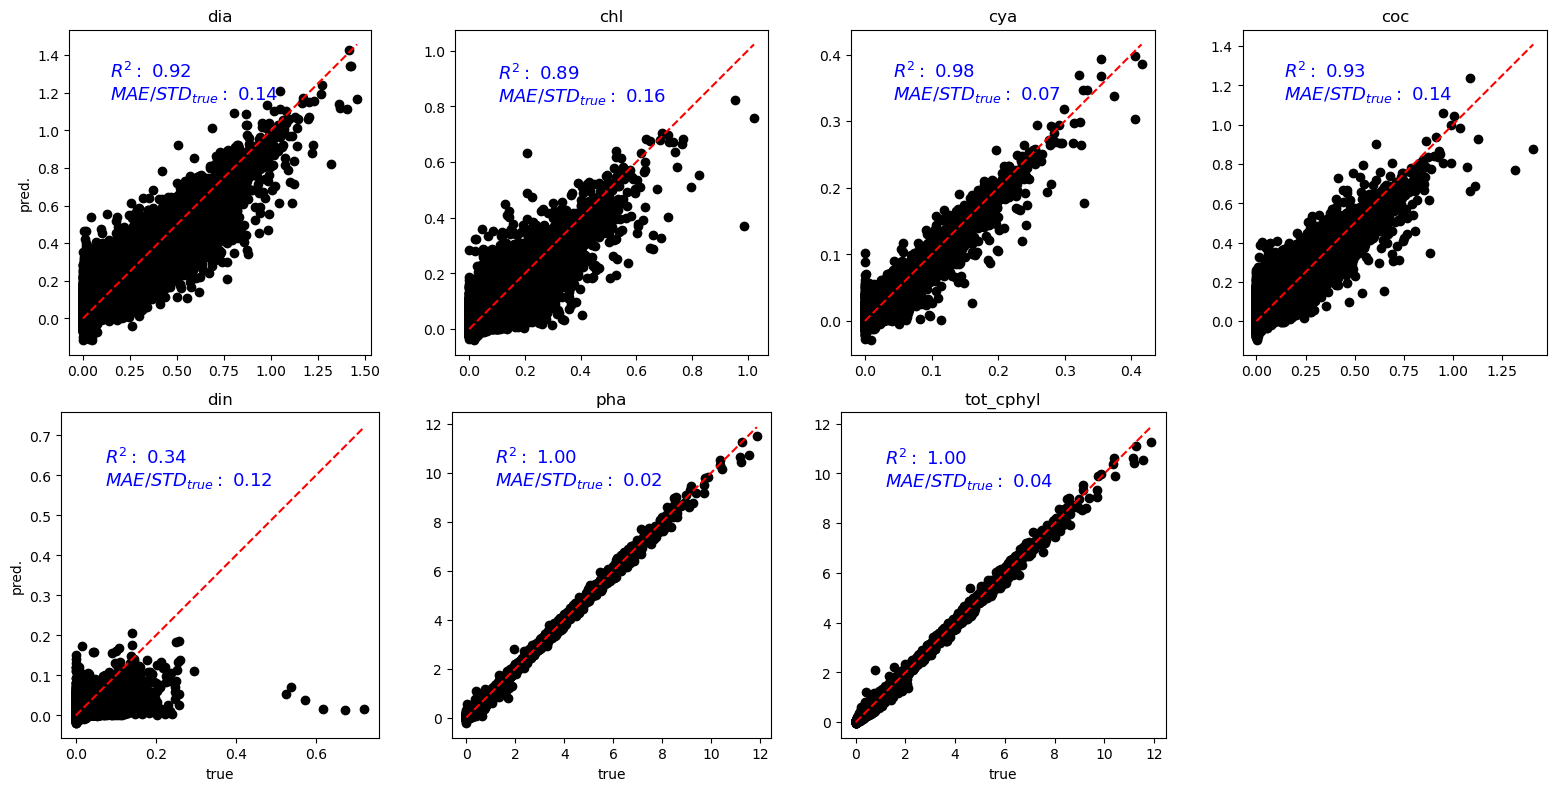

In [67]:
f, axs = pp.subplots(nrows=2, ncols=4, figsize=(16, 8))
for col, ax in zip(dY_test.columns, axs.ravel()):
    r2 = eval_scores[col]['r2']
    mae2truestd = eval_scores[col]['mae_2_true_std_ratio']
    string = r'$R^2:$ ' + f'{r2:.2f}\n' + r'$MAE/STD_{true}:$ ' + f'{mae2truestd:.2f}'
    plot_regression(dY_test[col], dY_pred[col], col, ax=ax, leg=string)
for ax in axs.ravel()[-1:]:
    ax.set_visible(False)
f.tight_layout()
f.savefig('goodness-of-fit_rrs_env.png', dpi=300)
f.savefig('goodness_of_fit_rrs_env.pdf', dpi=300)

In [59]:
model_nums = {k:i for i, k in enumerate(dY_test.columns)}
model_nums

{'dia': 0, 'chl': 1, 'cya': 2, 'coc': 3, 'din': 4, 'pha': 5, 'tot_cphyl': 6}

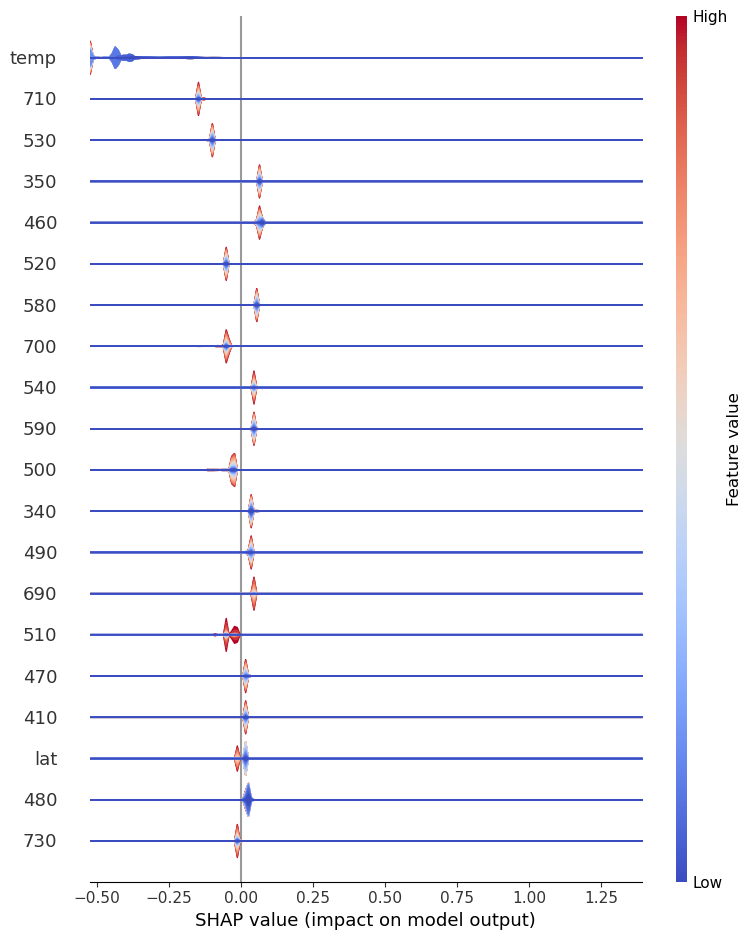

In [60]:
target = 'dia'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test)
main_features_dia = get_main_features(shap_vals, dX_test)
plot_shap(shap_values=shap_vals, X=dX_test, target_name=target, input_types='rrs_env')

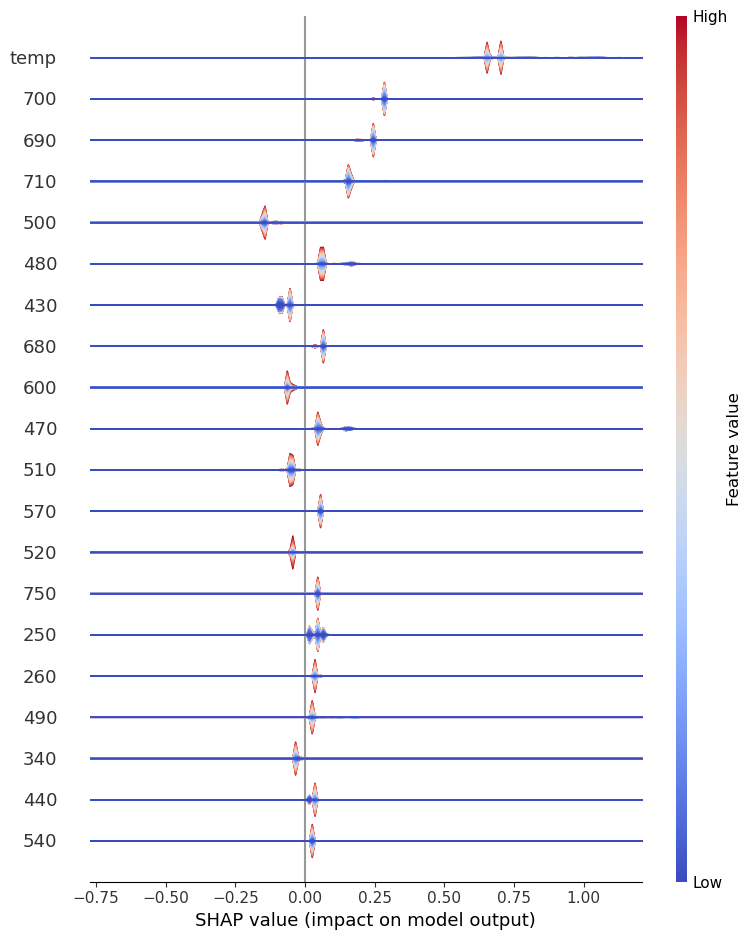

In [61]:
#{'dia': 0, 'chl': 1, 'cya': 2, 'coc': 3, 'din': 4, 'pha': 5, 'tot_cphyl': 6}
target = 'chl'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test)
main_features_dia = get_main_features(shap_vals, dX_test)
plot_shap(shap_values=shap_vals, X=dX_test, target_name=target, input_types='rrs_env')

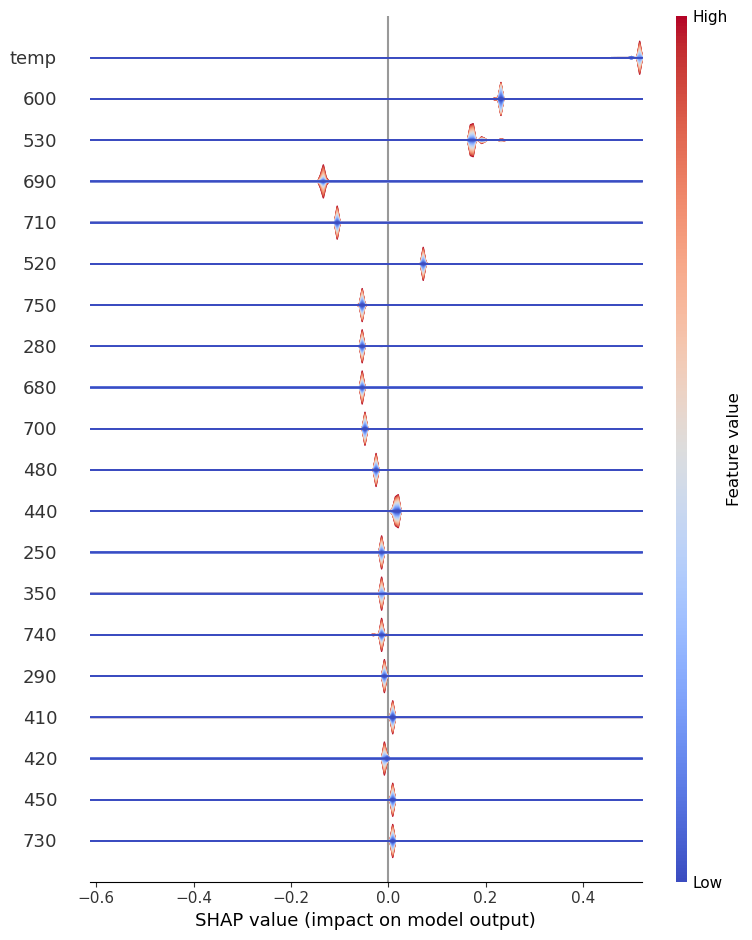

In [62]:
#{'dia': 0, 'chl': 1, 'cya': 2, 'coc': 3, 'din': 4, 'pha': 5, 'tot_cphyl': 6}
target = 'cya'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test)
main_features_dia = get_main_features(shap_vals, dX_test)
plot_shap(shap_values=shap_vals, X=dX_test, target_name=target, input_types='rrs_env')

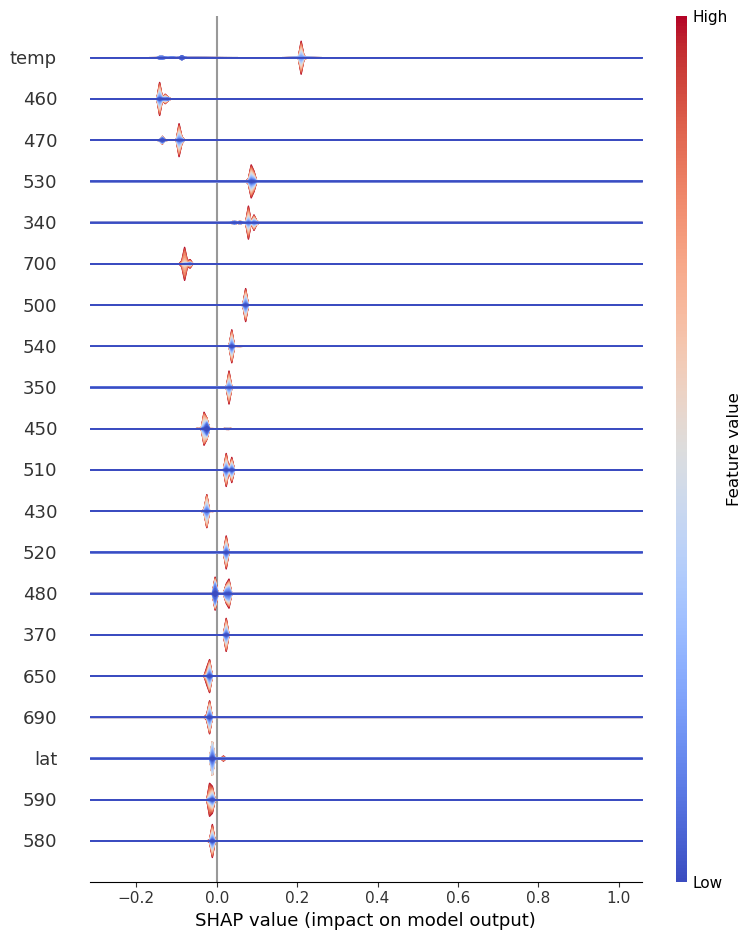

In [63]:
#{'dia': 0, 'chl': 1, 'cya': 2, 'coc': 3, 'din': 4, 'pha': 5, 'tot_cphyl': 6}
target = 'coc'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test)
main_features_coc = get_main_features(shap_vals, dX_test)
plot_shap(shap_values=shap_vals, X=dX_test, target_name=target, input_types='rrs_env')

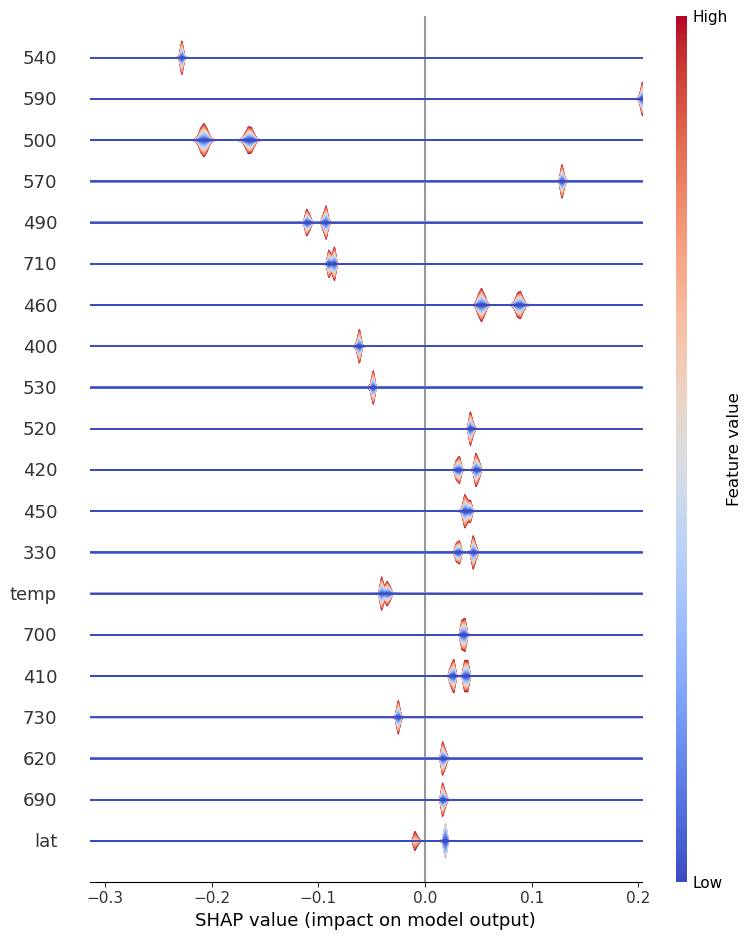

In [64]:
#{'dia': 0, 'chl': 1, 'cya': 2, 'coc': 3, 'din': 4, 'pha': 5, 'tot_cphyl': 6}
target = 'din'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test)
main_features_din = get_main_features(shap_vals, dX_test)
plot_shap(shap_values=shap_vals, X=dX_test, target_name=target, input_types='rrs_env')

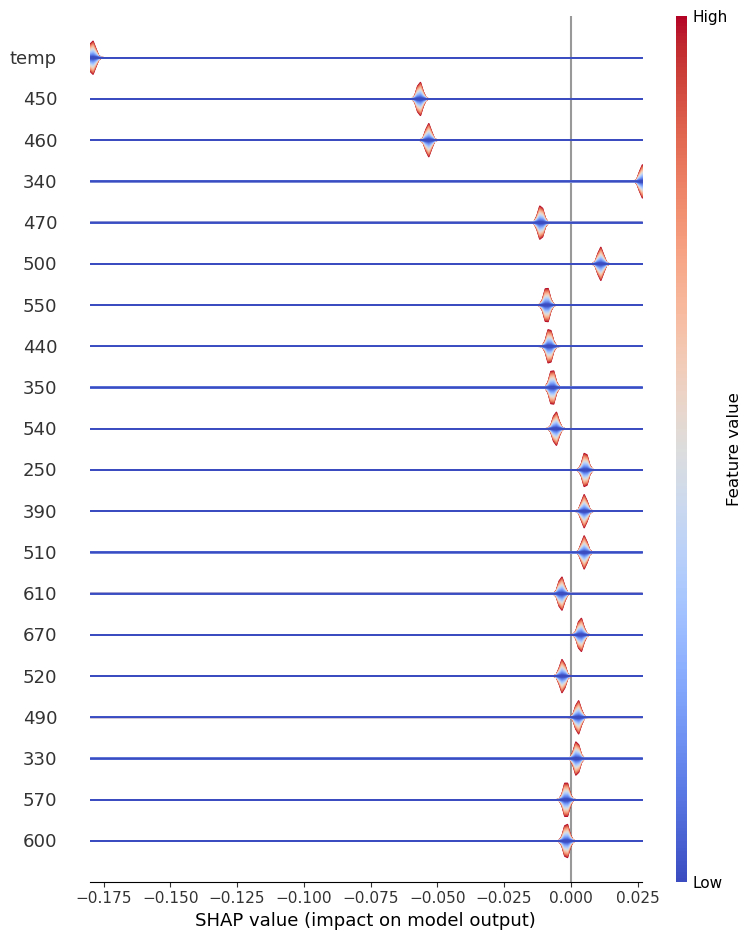

In [65]:
#{'dia': 0, 'chl': 1, 'cya': 2, 'coc': 3, 'din': 4, 'pha': 5, 'tot_cphyl': 6}
target = 'pha'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test)
main_features_pha = get_main_features(shap_vals, dX_test)
plot_shap(shap_values=shap_vals, X=dX_test, target_name=target, input_types='rrs_env')

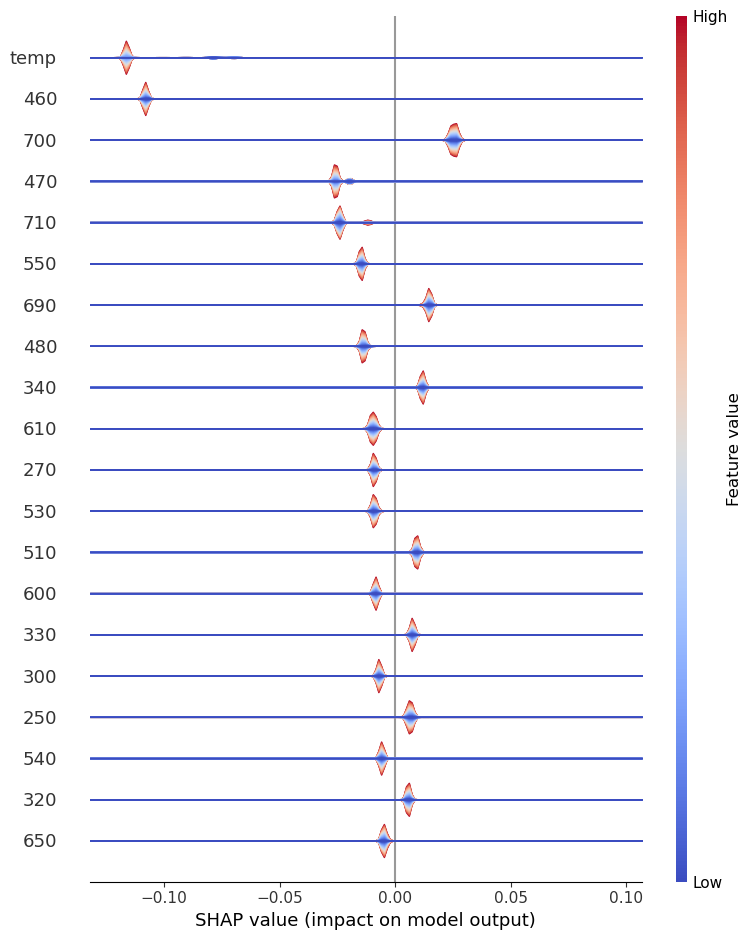

In [66]:
#{'dia': 0, 'chl': 1, 'cya': 2, 'coc': 3, 'din': 4, 'pha': 5, 'tot_cphyl': 6}
target = 'tot_cphyl'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test)
main_features_tot_cphyl = get_main_features(shap_vals, dX_test)
plot_shap(shap_values=shap_vals, X=dX_test, target_name=target, input_types='rrs_env')

Question: Why are dinos so hard to predict? What do the IOPs look like for dinos?